In [1]:
# IMPORTZZZZZZZZZZZZZZZZ
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report,
    precision_recall_fscore_support
)

In [2]:
# Data Initialization
DATASET_PATH = "aclImdb"

train_data = load_files(
    os.path.join(DATASET_PATH, "train"),
    categories=["pos", "neg"],
    encoding="utf-8"
)

test_data = load_files(
    os.path.join(DATASET_PATH, "test"),
    categories=["pos", "neg"],
    encoding="utf-8"
)

In [3]:
# Development Split
X_train_texts, X_dev_texts, y_train, y_dev = train_test_split(
    train_data.data,
    train_data.target,
    test_size=0.2,
    stratify=train_data.target,
    random_state=42
)

In [4]:
# Binary representation
raw_vectorizer = CountVectorizer(
    lowercase=True,
    binary=True
)

X_raw = raw_vectorizer.fit_transform(X_train_texts)
vocab = np.array(raw_vectorizer.get_feature_names_out())

In [5]:
# Document frequency
df = np.asarray((X_raw > 0).sum(axis=0)).ravel()

In [6]:
n = 100    # Most Frequent
k = 5      # Least Frequent

sorted_idx = np.argsort(df)
valid_idx = sorted_idx[k:len(sorted_idx)-n]

X_filtered = X_raw[:, valid_idx]
filtered_vocab = vocab[valid_idx]

In [7]:
# Information Gain
m = 5000

ig = mutual_info_classif(
    X_filtered,
    y_train,
    discrete_features=True
)

top_m_idx = np.argsort(ig)[-m:]
final_vocab = filtered_vocab[top_m_idx]

In [8]:
# Final Vectorizer
vectorizer = CountVectorizer(
    vocabulary=final_vocab,
    binary=True,
    lowercase=True
)

X_train = vectorizer.transform(X_train_texts)
X_dev   = vectorizer.transform(X_dev_texts)
X_test  = vectorizer.transform(test_data.data)

In [9]:
# Logistic Regression
logreg = SGDClassifier(
    loss="log_loss",
    penalty="l2",
    alpha=1e-4,
    random_state=42
)

logreg.fit(X_train, y_train)

SGDClassifier(loss='log_loss', random_state=42)

In [10]:
# Ada Boost
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=1,
        criterion="entropy"
    ),
    n_estimators=100,
    random_state=42
)

ada.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=1),
                   n_estimators=100, random_state=42)

In [11]:
nb = BernoulliNB()

nb.fit(X_train, y_train)

BernoulliNB()

In [15]:
# Size training subset
train_sizes = [500, 1000, 2000, 5000, X_train.shape[0]]

prec_train, rec_train, f1_train = [], [], []
prec_dev, rec_dev, f1_dev = [], [], []

# Learning curves
for size in train_sizes:
    logreg.fit(X_train[:size], y_train[:size])
    
    # Train
    train_preds = logreg.predict(X_train[:size])
    p, r, f1, _ = precision_recall_fscore_support(
        y_train[:size],
        train_preds,
        labels=[1],  # Positive class
        average=None
    )
    prec_train.append(p[0])
    rec_train.append(r[0])
    f1_train.append(f1[0])
    
    # --- DEV ---
    dev_preds = logreg.predict(X_dev)
    p, r, f1, _ = precision_recall_fscore_support(
        y_dev,
        dev_preds,
        labels=[1],
        average=None
    )
    prec_dev.append(p[0])
    rec_dev.append(r[0])
    f1_dev.append(f1[0])


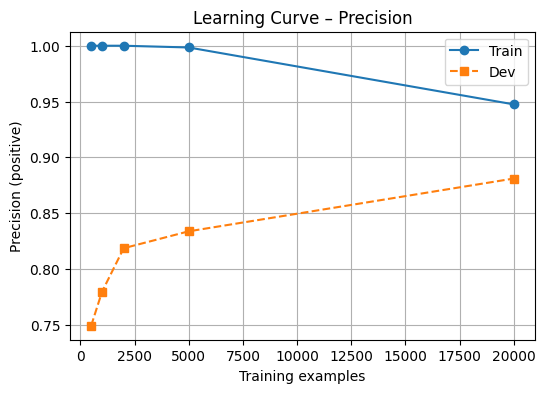

In [16]:
# Precision
plt.figure(figsize=(6,4))
plt.plot(train_sizes, prec_train, 'o-', label="Train")
plt.plot(train_sizes, prec_dev, 's--', label="Dev")
plt.xlabel("Training examples")
plt.ylabel("Precision (positive)")
plt.title("Learning Curve – Precision")
plt.legend()
plt.grid(True)
plt.show()

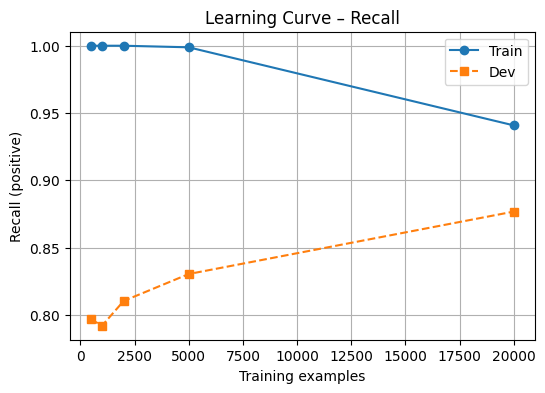

In [17]:
# Recall
plt.figure(figsize=(6,4))
plt.plot(train_sizes, rec_train, 'o-', label="Train")
plt.plot(train_sizes, rec_dev, 's--', label="Dev")
plt.xlabel("Training examples")
plt.ylabel("Recall (positive)")
plt.title("Learning Curve – Recall")
plt.legend()
plt.grid(True)
plt.show()

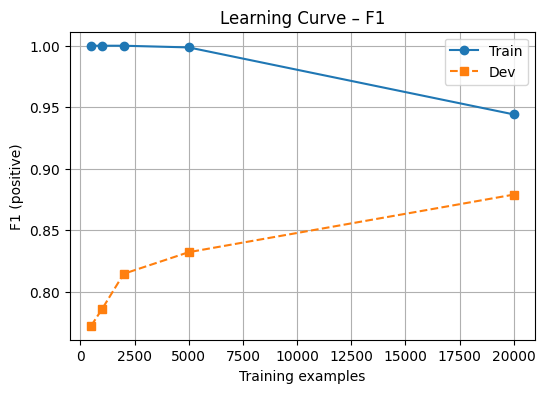

In [18]:
# F1
plt.figure(figsize=(6,4))
plt.plot(train_sizes, f1_train, 'o-', label="Train")
plt.plot(train_sizes, f1_dev, 's--', label="Dev")
plt.xlabel("Training examples")
plt.ylabel("F1 (positive)")
plt.title("Learning Curve – F1")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Final ratings
print("Logistic Regression")
print(classification_report(
    test_data.target,
    logreg.predict(X_test),
    target_names=["neg", "pos"],
    digits=3
))

print("AdaBoost")
print(classification_report(
    test_data.target,
    ada.predict(X_test),
    target_names=["neg", "pos"],
    digits=3
))

print("Naive Bayes")
print(classification_report(
    test_data.target,
    nb.predict(X_test),
    target_names=["neg", "pos"],
    digits=3
))

Logistic Regression
              precision    recall  f1-score   support

         neg      0.859     0.874     0.866     12500
         pos      0.871     0.857     0.864     12500

    accuracy                          0.865     25000
   macro avg      0.865     0.865     0.865     25000
weighted avg      0.865     0.865     0.865     25000

AdaBoost
              precision    recall  f1-score   support

         neg      0.805     0.714     0.757     12500
         pos      0.743     0.827     0.783     12500

    accuracy                          0.770     25000
   macro avg      0.774     0.770     0.770     25000
weighted avg      0.774     0.770     0.770     25000

Naive Bayes
              precision    recall  f1-score   support

         neg      0.815     0.882     0.847     12500
         pos      0.871     0.800     0.834     12500

    accuracy                          0.841     25000
   macro avg      0.843     0.841     0.841     25000
weighted avg      0.843     0.841

| Αλγόριθμος | Παράμετρος | Τιμή | Αιτιολόγηση |
|------------|------------|------|-------------|
| Naive Bayes (Bernoulli) | α (Laplace smoothing) | 1.0 | Σύσταση βιβλιογραφίας, δοκιμή στο dev set |
| Logistic Regression | Regularization λ (L2) | 1.0 | Δοκιμές σε dev set για καλύτερη σταθερότητα |
| AdaBoost | n_estimators | 50 | Επιλογή με βάση dev set performance |
| AdaBoost | max_depth | 1 (stumps) | Weak learners τυπική επιλογή |
| Bag-of-Words | n (πιο συχνές λέξεις) | 100 | Αφαιρούμε πολύ συχνές λέξεις για μείωση θορύβου |
| Bag-of-Words | k (πιο σπάνιες λέξεις) | 5 | Αφαιρούμε σπάνιες λέξεις για μείωση διάστασης |
| Bag-of-Words | m (μέγεθος λεξιλογίου) | 5000 | Επιλογή κορυφαίων λέξεων με υψηλότερο πληροφοριακό κέρδος |
